In [1]:
import zipfile

import pylab as pl
import requests
import torch
from fontTools.misc import transform
from fsspec.utils import infer_compression
from jupyterlab.extensions import entry
from torch import nn
from pathlib import Path


datapath = Path("data/")
imagepath = datapath/"pizza_steak_sushi"

if imagepath.is_dir():
    print(f"{imagepath} exists")
else:
    print(f"{imagepath} does not exist")
    imagepath.mkdir(parents=True, exist_ok=True)

with open(datapath/"pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

with zipfile.ZipFile(datapath/"pizza_steak_sushi.zip","r") as zip_ref:
    zip_ref.extractall(imagepath)

data/pizza_steak_sushi exists


imageclass: sushi
imagepath: 512
imagepath: 512


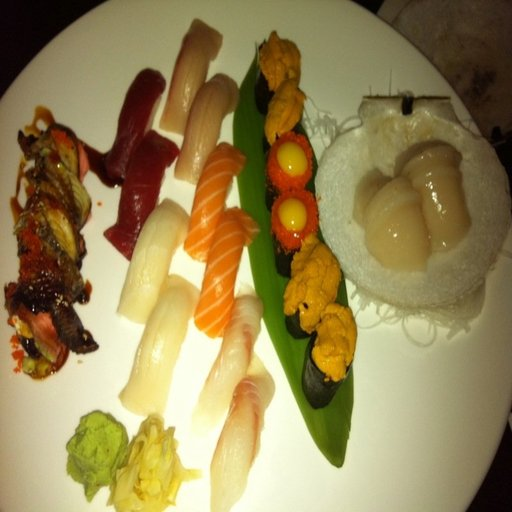

In [2]:
import random
from PIL import Image

imagepathlist = list(imagepath.glob('*/*/*.jpg'))

randomiamgepath = random.choice(imagepathlist)

imageclass = randomiamgepath.parent.stem
img = Image.open(randomiamgepath)
print(f'imageclass: {imageclass}')
print(f'imagepath: {img.width}')
print(f'imagepath: {img.height}')
img

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"


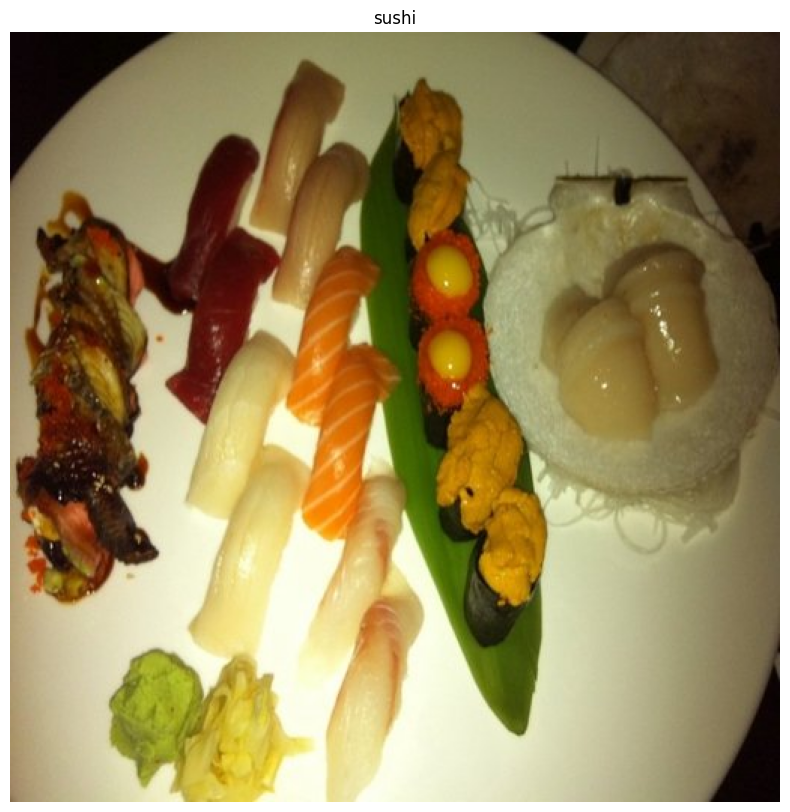

In [4]:
import numpy as np
import matplotlib.pyplot as plt

imgasarray = np.asarray(img)

plt.figure(figsize=(10,10))
plt.imshow(imgasarray)
plt.title(imageclass)
plt.axis('off')
plt.show()

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms,datasets

In [6]:
datatransform = transforms.Compose([
    transforms.Resize(size=(64,64)),#resize images into same shapes
    transforms.RandomHorizontalFlip(p=0.5),#flip images
    transforms.ToTensor(),#turn images into tensors
])

In [7]:
datatransform(img).shape,datatransform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

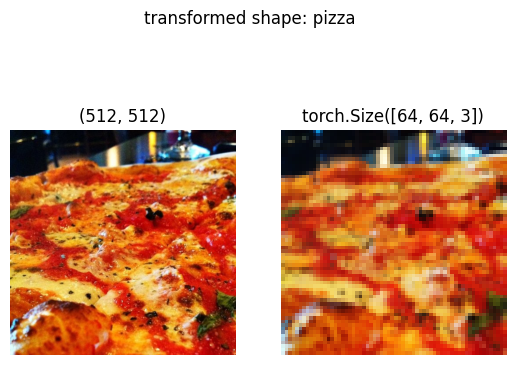

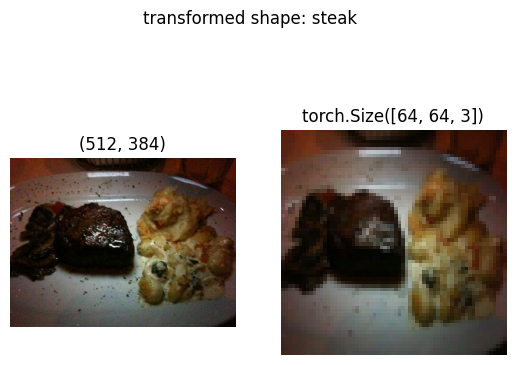

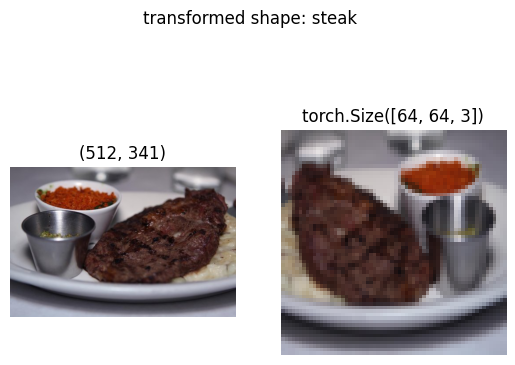

In [8]:
def plottransformedimages(imagepath : list,transform,n=3,seed=None):
    if seed:
        random.seed(seed)
    randomimgpath = random.sample(imagepath,k=n)
    for imagepath in randomimgpath:
        with Image.open(imagepath) as f:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'{f.size}')
            ax[0].axis(False)

            tarnformedimage = transform(f).permute(1,2,0)
            # c,h,w -> h,w,c  changing order of colour channel
            ax[1].imshow(tarnformedimage)
            ax[1].set_title(f'{tarnformedimage.shape}')
            ax[1].axis(False)

            fig.suptitle(f'transformed shape: {imagepath.parent.stem}')

plottransformedimages(imagepathlist,datatransform,n=3,seed=42)


# load the image

In [9]:
from torchvision import datasets
traindr = "data/pizza_steak_sushi/train"
testdir = "data/pizza_steak_sushi/test"

train_data = datasets.ImageFolder(
    root=traindr,
    transform=datatransform,
    target_transform = None
)

test_data = datasets.ImageFolder(root=testdir,transform=datatransform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [10]:
classdict = train_data.class_to_idx
classdict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [11]:
img ,label = train_data[0][0],train_data[0][1]
print(f'img: {img}')
print(f'img shape: {img.shape}')
print(f'img dtype: {img.dtype}')
print(f'label : {label}')
print(f'label dtype: {type(label)}')

img: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.015

In [12]:
from torch.utils.data import DataLoader
batchsize=1
traindataloader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
testdataloader = DataLoader(test_data,batch_size=batchsize,shuffle=True)
#we can use these for experiments

# laoding custom dataset

In [13]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple,Dict,List

In [14]:
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [15]:
classnamesindir = sorted([entry.name for entry in list(os.scandir(traindr))])
#gives classnames in our folder

In [16]:
classnamesindir

['pizza', 'steak', 'sushi']

In [17]:
# fntn to find classsnames in custom dir
def findclasses(directory:str)->Tuple[List[str],Dict[str,int]]:
    classess = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())
    if not classess:
        raise FileNotFoundError("couldn't find any file")
    classtoidx = {classname: i for i ,classname in enumerate(classess)}
    return classess,classtoidx

In [18]:
findclasses(traindr)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [19]:
#custom dataset class
from torch.utils.data import Dataset

class Imagefoldercustome(Dataset):
    def __init__(self,targdir:str,transform=None):
        self.paths = list(pathlib.Path(targdir).glob("*/*.jpg"))#path for dir
        self.transform = transform # transform data
        self.classess ,self.classtoidx = findclasses(targdir)#find classess of images

    def loadimage(self,index:int)->Image.Image:#load images
        imagepath = self.paths[index]
        return Image.open(imagepath)

    def __len__(self)->int:#return length of dataset (overwriting default method)
        return len(self.paths)

    def __getitem__(self, index:int)->Tuple[torch.Tensor,int]:# return a particular sample
        img = self.loadimage(index)
        classname = self.paths[index].parent.name
        classidx = self.classtoidx[classname]
        if self.transform:#transform if needed only
            return self.transform(img),classidx
        else:# return img and classidx without transforming
            return img,classidx



In [20]:
traintransform = transforms.Compose([
    transforms.Resize(size=(64,64)),#resize images into same shapes
    transforms.RandomHorizontalFlip(p=0.5),#flip images
    transforms.ToTensor(),#turn images into tensors
])

testtransform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [21]:
traincustomdata = Imagefoldercustome(traindr,traintransform)
testcustomdata = Imagefoldercustome(testdir,testtransform)

In [22]:
len(traincustomdata),len(testcustomdata)

(225, 75)

In [23]:
def randomimages(dataset:torch.utils.data.Dataset,classess:List[str]=None,n:int=10,displayshape=None,seed:int=None):
    if n>10:
        n=10
        displayshape=False
        print(f'for display n shoudlnot be larger than 10')

    if seed:
        random.seed(seed)

    randomsampleidx = random.sample(range(len(dataset)),k=n)

    plt.figure(figsize=(10,10))

    for i ,targetsample in enumerate(randomsampleidx):
        targetimage,targetlabel = dataset[targetsample][0],dataset[targetsample][1]
        targetimageadj = targetimage.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(targetimageadj)
        plt.axis('off')
        if classess:
            title = f"class : {classess[targetlabel]}"
            if displayshape:
                title = f" class : {targetimageadj.shape}"
        plt.title(title)

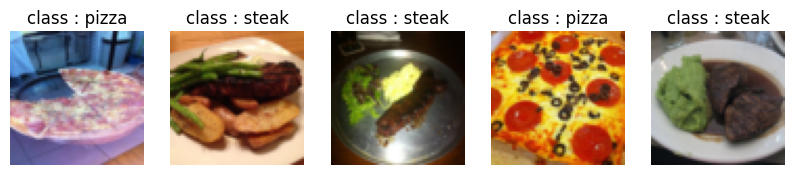

In [24]:
randomimages(traincustomdata,n=5,classess=classnamesindir,seed=42)

In [25]:
#custom dataloaders
from torch.utils.data import DataLoader
batch_size = 32
numworkers = os.cpu_count()

traindataloadercustom = DataLoader(dataset=traincustomdata,batch_size=batch_size,shuffle=True,num_workers=0)
testdataloadercustom = DataLoader(dataset=testcustomdata,batch_size=batch_size,shuffle=True,num_workers=0)
traindataloadercustom,testdataloadercustom

(<torch.utils.data.dataloader.DataLoader at 0x1561c51d0>,
 <torch.utils.data.dataloader.DataLoader at 0x155f209d0>)

In [26]:
imgcustom,lablecustom = next(iter(traindataloadercustom))
imgcustom.shape,lablecustom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# Data Augmentation

In [27]:
from torchvision import transforms

traintransfromdata= transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])

testtransfromdata = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
])

traintransfromdata,testtransfromdata

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

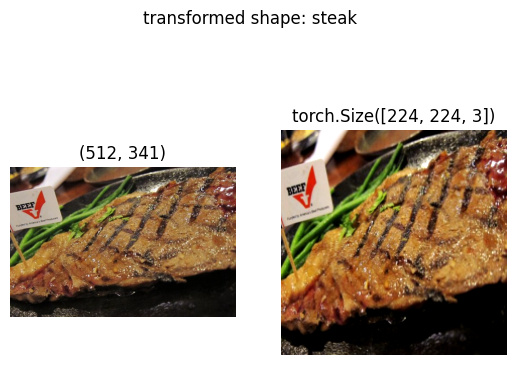

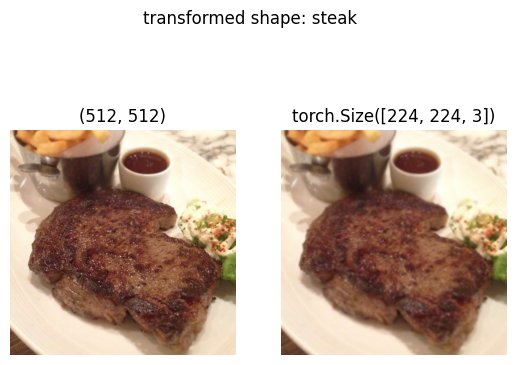

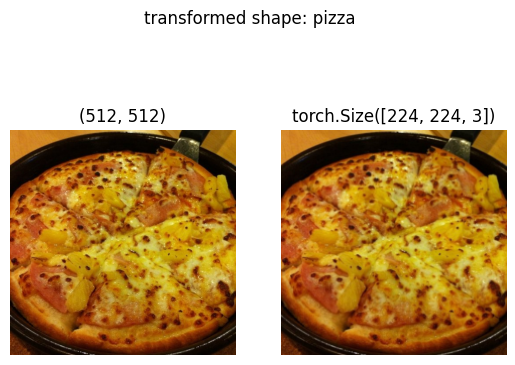

In [28]:
plottransformedimages(
    imagepathlist,traintransfromdata,n=3,seed=None
)

# Model0 - without augmentation
tinyVGG arch

In [29]:
simpletransform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor(),
])

In [30]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

traindatasample = datasets.ImageFolder(
    root=traindr,
    transform=simpletransform,
)

testdatasample = datasets.ImageFolder(
    root=testdir,
    transform=simpletransform,
)


batcsize = 32
numworkers = os.cpu_count()

train_data_loader = DataLoader(
    dataset=traindatasample,
    batch_size=batcsize,
    shuffle=True,
    num_workers=numworkers,
)
test_data_loader = DataLoader(
    dataset=testdatasample,
    batch_size=batcsize,
    shuffle=True,
    num_workers=numworkers,
)

In [31]:
class tinyVGG(nn.Module):
    def __init__(self,inputshape:int,hiddenunits:int,outptshape:int):
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels=inputshape,out_channels=hiddenunits,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hiddenunits,out_channels=hiddenunits,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=hiddenunits,out_channels=hiddenunits,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hiddenunits,out_channels=hiddenunits,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hiddenunits*16*16,out_features=outptshape),
        )

    def forward(self,x):
        x = self.convblock(x)
        x = self.convblock2(x)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.convblock2(self.convblock(x)))

In [32]:
torch.manual_seed(42)
model0= tinyVGG(inputshape=3,outptshape=len(classnamesindir),hiddenunits=10).to(device)
model0

tinyVGG(
  (convblock): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [33]:
imgbatch ,label = next(iter(train_data_loader))
print(imgbatch.shape)

torch.Size([32, 3, 64, 64])


In [34]:
model0(imgbatch.to(device))

tensor([[0.0578, 0.0634, 0.0351],
        [0.0657, 0.0650, 0.0398],
        [0.0702, 0.0678, 0.0412],
        [0.0687, 0.0646, 0.0417],
        [0.0625, 0.0613, 0.0355],
        [0.0587, 0.0595, 0.0358],
        [0.0634, 0.0637, 0.0376],
        [0.0653, 0.0615, 0.0376],
        [0.0678, 0.0621, 0.0349],
        [0.0620, 0.0599, 0.0371],
        [0.0607, 0.0628, 0.0387],
        [0.0638, 0.0589, 0.0352],
        [0.0658, 0.0611, 0.0369],
        [0.0703, 0.0689, 0.0330],
        [0.0557, 0.0571, 0.0356],
        [0.0632, 0.0642, 0.0388],
        [0.0639, 0.0616, 0.0375],
        [0.0605, 0.0600, 0.0374],
        [0.0623, 0.0627, 0.0368],
        [0.0740, 0.0676, 0.0400],
        [0.0621, 0.0613, 0.0361],
        [0.0632, 0.0599, 0.0366],
        [0.0662, 0.0627, 0.0334],
        [0.0637, 0.0622, 0.0394],
        [0.0670, 0.0666, 0.0363],
        [0.0650, 0.0601, 0.0405],
        [0.0639, 0.0597, 0.0395],
        [0.0733, 0.0687, 0.0412],
        [0.0697, 0.0631, 0.0402],
        [0.062

In [35]:
#to get the summary of model
from torchinfo import summary
summary(model0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
tinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

train and test model

In [36]:
def trainstep(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,optimizer:torch.optim.Optimizer,lossfn,device:torch.device=None):
    model.train()
    trainloss,trainacc = 0,0

    for batch ,(x,y) in enumerate(dataloader):
        x,y=x.to(device),y.to(device)
        ypred = model(x)
        loss = lossfn(ypred, y)
        trainloss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ypredclass = torch.argmax(torch.softmax(ypred,dim=1),dim=1)
        trainacc += (ypredclass == y).sum().item()/len(ypred)

    trainloss = trainloss/len(dataloader)
    trainacc = trainacc/len(dataloader)
    return trainloss,trainacc



In [37]:
def teststep(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,lossfn,device :torch.device=None):
    model.eval()
    testloss,testacc = 0,0
    with torch.inference_mode():
        for batch,(x,y) in enumerate(dataloader):
            x,y = x.to(device),y.to(device)
            testpred = model(x)
            loss = lossfn(testpred, y)
            testloss += loss.item()
            testpredlabel = torch.argmax(torch.softmax(testpred,dim=1),dim=1)
            testacc += (testpredlabel == y).sum().item()/len(testpredlabel)
    testloss = testloss/len(dataloader)
    testacc = testacc/len(dataloader)
    return testloss,testacc


In [38]:
from tqdm import tqdm

#fntn to train and loop through epochs
def train(model:torch.nn.Module,traindataloader:torch.utils.data.DataLoader,testdataloader:torch.utils.data.DataLoader,optimizer,lossfn:nn.CrossEntropyLoss(),epochs:int=5,device=None):
    results = {
        "trainloss":[],
        "trainacc":[],
        "testloss":[],
        "testacc":[],
    }
    for epoch in tqdm(range(epochs)):
        trainloss,trainacc = trainstep(model,traindataloader,optimizer,lossfn,device)
        testloss,testacc = teststep(model,testdataloader,lossfn,device)
        print(f'epoch: {epoch} , trainloss:{trainloss},testloss:{testloss},trainacc:{trainacc},testacc:{testacc}')
        results["trainloss"].append(trainloss)
        results["trainacc"].append(trainacc)
        results["testloss"].append(testloss)
        results["testacc"].append(testacc)

    return results


In [39]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.mps.manual_seed(42)
epochs = 5

model_1 = tinyVGG(inputshape=3,hiddenunits=10,outptshape=len(classnamesindir)).to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=0.001)

starttime = timer()
model_1result = train(model=model_1,traindataloader=traindataloader,testdataloader=testdataloader,optimizer=optimizer,lossfn=lossfn,epochs=5,device=device)
endtime = timer()
print(f'training time: {endtime-starttime}')

 20%|██        | 1/5 [00:01<00:05,  1.47s/it]

epoch: 0 , trainloss:1.1170152478747897,testloss:1.0973694070180258,trainacc:0.29777777777777775,testacc:0.36


 40%|████      | 2/5 [00:02<00:04,  1.40s/it]

epoch: 1 , trainloss:1.0997585005230375,testloss:1.0982374811172486,trainacc:0.29333333333333333,testacc:0.3333333333333333


 60%|██████    | 3/5 [00:04<00:02,  1.37s/it]

epoch: 2 , trainloss:1.0988632271024916,testloss:1.0985244162877401,trainacc:0.3511111111111111,testacc:0.30666666666666664


 80%|████████  | 4/5 [00:05<00:01,  1.36s/it]

epoch: 3 , trainloss:1.1000541342629326,testloss:1.0965751266479493,trainacc:0.35555555555555557,testacc:0.41333333333333333


100%|██████████| 5/5 [00:06<00:00,  1.37s/it]

epoch: 4 , trainloss:1.0412490099337366,testloss:1.010640344619751,trainacc:0.56,testacc:0.49333333333333335
training time: 6.846962791999999


In [40]:
def plotcurvesloss(result:Dict[str,List[float]]):
    loss = result["trainloss"]
    testloss = result["testloss"]
    acc = result["trainacc"]
    testacc = result["testacc"]

    epochs = range(len(result["trainloss"]))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label="trainloss")
    plt.plot(epochs,testloss,label="testloss")
    plt.title("Training Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs,acc,label="trainacc")
    plt.plot(epochs,testacc,label="testacc")
    plt.title("Training Accuracy")
    plt.legend()
    plt.show()

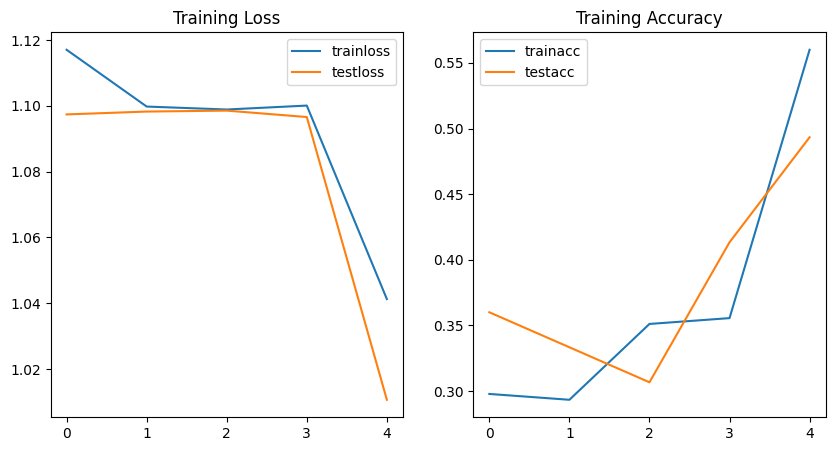

In [41]:
plotcurvesloss(model_1result)

# model_2 - with Augmented data

In [42]:
from torchvision import transforms

# 1. transform data
traindatatrivial = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
])
testdatatrivial = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [43]:
from torchvision import datasets
# 2. Augment data
augmentedtraindata = datasets.ImageFolder(traindr,transform=traindatatrivial)
augmentedtestdata = datasets.ImageFolder(testdir,transform=testdatatrivial)

In [44]:
import os
from torch.utils.data import DataLoader
# 3. create datalaoder
batchsize = 32
numworkers = os.cpu_count()

torch.manual_seed(42)

augmentedtraindataloader = DataLoader(augmentedtraindata,batch_size=batchsize,num_workers=numworkers,shuffle=False)
augmentedtestdataloader = DataLoader(augmentedtestdata,batch_size=batchsize,num_workers=numworkers,shuffle=False)

In [45]:
torch.manual_seed(42)

model_2 = tinyVGG(inputshape=3,hiddenunits=10,outptshape=len(augmentedtraindata.classes)).to(device)

 20%|██        | 1/5 [00:59<03:56, 59.13s/it]

epoch: 0 , trainloss:1.4578876048326492,testloss:1.1049419244130452,trainacc:0.1796875,testacc:0.2604166666666667


 40%|████      | 2/5 [01:58<02:57, 59.08s/it]

epoch: 1 , trainloss:1.0985293239355087,testloss:1.0997671683629353,trainacc:0.3046875,testacc:0.19791666666666666


 60%|██████    | 3/5 [02:57<01:57, 59.00s/it]

epoch: 2 , trainloss:1.0978705435991287,testloss:1.0956712166468303,trainacc:0.40234375,testacc:0.5416666666666666


 80%|████████  | 4/5 [03:56<00:59, 59.24s/it]

epoch: 3 , trainloss:1.0968427956104279,testloss:1.0919199387232463,trainacc:0.40234375,testacc:0.5416666666666666


100%|██████████| 5/5 [04:55<00:00, 59.16s/it]

epoch: 4 , trainloss:1.095935508608818,testloss:1.0884581804275513,trainacc:0.40234375,testacc:0.5416666666666666
training time: 295.82159416700006


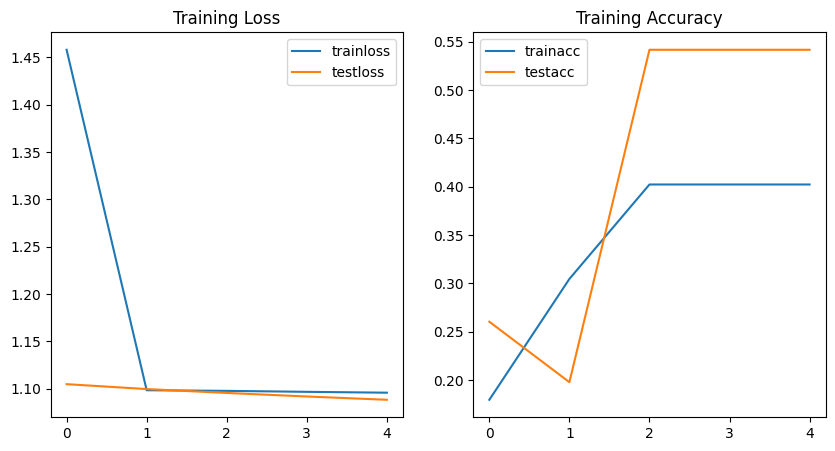

In [124]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs= 5

lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),lr=0.01)
starttime = timer()
model_2result = train(model_2,augmentedtraindataloader,augmentedtestdataloader,optimizer,lossfn,epochs=5,device=device)
endtime = timer()
print(f'training time: {endtime-starttime}')
plotcurvesloss(model_2result)

In [125]:
import pandas as pd
reslt1 = pd.DataFrame(model_1result)
result2 = pd.DataFrame(model_2result)

In [126]:
reslt1

,trainloss,trainacc,testloss,testacc
0,1.117015,0.297778,1.097369,0.360000
1,1.099759,0.293333,1.098237,0.333333
2,1.098863,0.351111,1.098524,0.306667
3,1.100054,0.355556,1.096575,0.413333
4,1.041249,0.560000,1.010640,0.493333


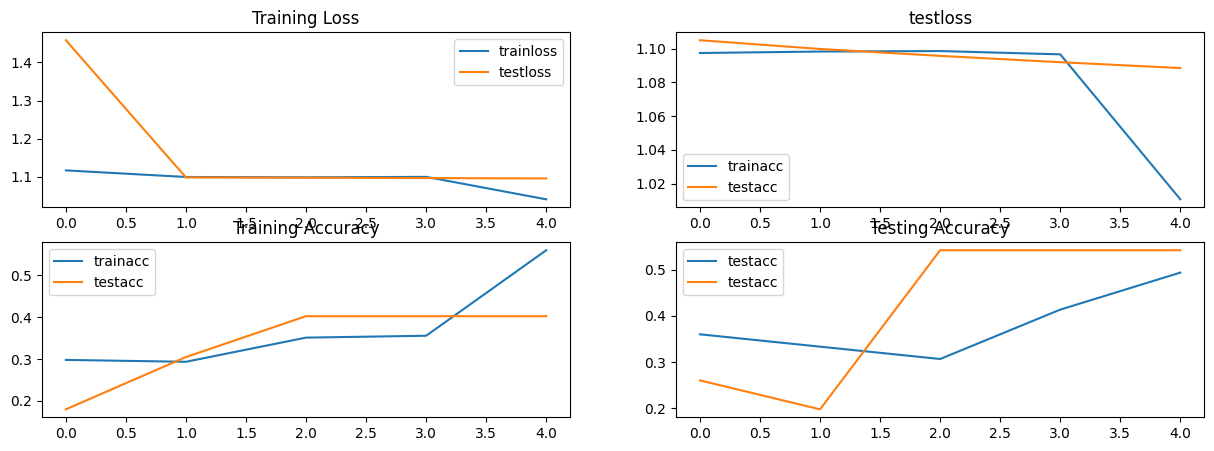

In [127]:
epochs = range(len(reslt1))
plt.figure(figsize=(15,5))
plt.subplot(2,2,1)
plt.plot(epochs,reslt1["trainloss"],label="trainloss")
plt.plot(epochs,result2["trainloss"],label="testloss")
plt.title("Training Loss")
plt.legend()
plt.subplot(2,2,2)
plt.plot(epochs,reslt1["testloss"],label="trainacc")
plt.plot(epochs,result2["testloss"],label="testacc")
plt.title("testloss")
plt.legend()
plt.subplot(2,2,3)
plt.plot(epochs,reslt1["trainacc"],label="trainacc")
plt.plot(epochs,result2["trainacc"],label="testacc")
plt.title("Training Accuracy")
plt.legend()
plt.subplot(2,2,4)
plt.plot(epochs,reslt1["testacc"],label="testacc")
plt.plot(epochs,result2["testacc"],label="testacc")
plt.title("Testing Accuracy")
plt.legend()
plt.show()

prediction on custom image

In [234]:
import torchvision

customimgpath = "/path"
#read image from path
customimage = torchvision.io.read_image(str(customimgpath))
print(customimage.shape)

torch.Size([3, 1280, 960])


In [201]:
#change shape of image into 64,64 bcz our model is trained on that size

customimg = torchvision.io.read_image(str(customimgpath)).type(torch.float32) /255.
customimg.dtype

torch.float32

In [202]:
#create a transformer to convert size of image and pass the image to it
customimgtransform = transforms.Compose([
    transforms.Resize(size=(64,64)),
])

transfromedimage = customimgtransform(customimage).type(torch.float32)
transfromedimage.dtype,transfromedimage.shape

(torch.float32, torch.Size([3, 64, 64]))

In [203]:
#evaluate model on custom image
model_2.eval()
with torch.inference_mode():
    model_2resultcustom = model_2(transfromedimage.unsqueeze(0).to(device))

In [204]:
model_2resultcustom

tensor([[-0.0253, -0.0178,  0.0298]], device='mps:0')

In [205]:
classnamesindir

['pizza', 'steak', 'sushi']

In [206]:
custompredprob = torch.softmax(model_2resultcustom,dim=1)
custompredprob

tensor([[0.3263, 0.3288, 0.3448]], device='mps:0')

In [207]:
custompredprob = torch.argmax(custompredprob,dim=1).cpu()
custompredprob

tensor([2])

In [208]:
classnamesindir[custompredprob]

'sushi'

In [218]:
def predandplot(model:torch.nn.Module,image:str,classnames:List[str]=None,transform=None,device=device):
    targetimg = torchvision.io.read_image(str(image)).type(torch.float32)
    targetimg = targetimg/255.

    if transform:
        targetimage = transform(targetimg)

    model.eval()
    with torch.inference_mode():
        targetimage = targetimage.unsqueeze(0)
        targetimgpred = model(targetimage.to(device))

    targetpredprobs = torch.softmax(targetimgpred,dim=1)
    targetpred = torch.argmax(targetpredprobs,dim=1)

    plt.imshow(targetimage.squeeze().permute(1,2,0))
    if classnames:
        title = f"predicted {classnamesindir[targetpred.cpu()]} | prob: {targetpredprobs.max().cpu()}"
    else:
        title = f"predicted {classnamesindir[targetpred]} | prob: {targetpredprobs.max().cpu()}"
    plt.title(title)
    plt.axis('off')


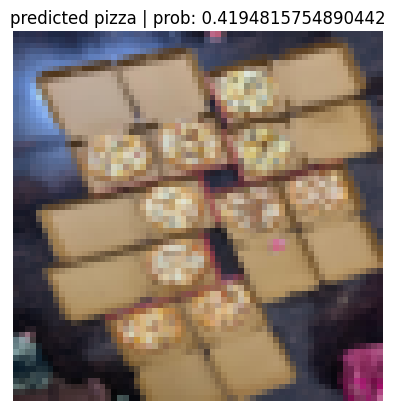

In [235]:
predandplot(model=model_1,image=customimgpath,classnames=classnamesindir,transform=customimgtransform,device=device)

In [ ]:
### model 1 is doing best than model 2